In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_co2_emissions.csv"
df_co2 = pd.read_csv(url)

url2 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_renewable_energy.csv"
df_green_energy = pd.read_csv(url2)

url3 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/annual_population.csv"
df_population = pd.read_csv(url3, on_bad_lines='skip')
df_population = df_population.loc[:, ['Country name', 'Year', 'Population']]
df_population = df_population.rename(columns={'Country name': 'Entity'})

url4 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/GDP.csv"
df_GDP = pd.read_csv(url4)

url5 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/gini_coefficient.csv"
df_gini = pd.read_csv(url5)

url6 = "https://raw.githubusercontent.com/pekpekkis/Data-Management-Group-Project/main/continents.csv"
df_continents = pd.read_csv(url6)
df_continents = df_continents.drop('Year', axis='columns')

df_combined = df_co2.merge(df_green_energy, how='left', on=['Entity', 'Code', 'Year']).merge(df_population, how='left', on=['Entity', 'Year']).merge(df_GDP, how='left', on=['Entity', 'Code', 'Year']).merge(df_gini, how='left', on=['Entity', 'Code', 'Year']).merge(df_continents, how='left', on=['Entity', 'Code'])

df_combined['GDP per capita'] = df_combined['GDP (constant 2015 US$)'] / df_combined['Population']

def income_dummies(row):
    if row['GDP per capita'] < 1036:
        return 1, 0, 0, 0
    elif row['GDP per capita'] >= 1036 and row['GDP per capita'] < 4045:
        return 0, 1, 0, 0
    elif row['GDP per capita'] >= 4045 and row['GDP per capita'] < 12535:
        return 0, 0, 1, 0
    elif row['GDP per capita'] >= 12535:
        return 0, 0, 0, 1
    else:
        return 0, 0, 0, 0

df_combined[['Low income', 'Lower-middle income', 'Upper-middle income', 'High income']] = df_combined.apply(income_dummies, axis=1, result_type='expand')

def geo_dummies(row):
    if row['Continent'] == 'Africa':
        return 1, 0, 0, 0, 0, 0
    elif row['Continent'] == 'Asia':
        return 0, 1, 0, 0, 0, 0
    elif row['Continent'] == 'Europe':
        return 0, 0, 1, 0, 0, 0
    elif row['Continent'] == 'North America':
        return 0, 0, 0, 1, 0, 0
    elif row['Continent'] == 'South America':
        return 0, 0, 0, 0, 1, 0
    else:
        return 0, 0, 0, 0, 0, 1

df_combined[['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']] = df_combined.apply(geo_dummies, axis=1, result_type='expand')

df_combined = df_combined.rename(columns={'Entity': 'Country', 'Annual CO₂ emissions': 'CO2 emissions', 'Renewables (% equivalent primary energy)': 'Renewable energy %', 'GDP (constant 2015 US$)': 'GDP', 'Gini coefficient': 'Gini'})
df_combined.loc[df_combined['Country'] == 'United States', 'Country'] = 'United States of America'
df_combined.loc[df_combined['Country'] == "Cote d'Ivoire", 'Country'] = "Côte d'Ivoire"
df_combined['CO2 emissions'] = df_combined['CO2 emissions'] / 1000000
df_combined = df_combined[df_combined['Code'].notna()]
df_combined = df_combined.drop('Code', axis='columns')
df_combined = df_combined.drop(df_combined[df_combined['Country'] == 'World'].index, axis=0)

df_2020 = df_combined.loc[df_combined.Year == 2020]
df_2020.dropna()

import numpy as np
import os
import matplotlib.pyplot as plt

df_clean = df_combined.dropna()
df_clean['CO2 emissions_log'] = np.log(df_clean['CO2 emissions'])

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_9184\1632926206.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CO2 emissions_log'] = np.log(df_clean['CO2 emissions'])


In [2]:
import numpy as np

threshold = 1

z_scores = np.abs((df_clean['CO2 emissions_log'] - df_clean['CO2 emissions_log'].mean()) / df_clean['CO2 emissions_log'].std())

outliers = df_clean[z_scores > threshold]

df_clean_without_outliers = df_clean[z_scores <= threshold]

df_clean_without_outliers.reset_index(drop=True, inplace=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("Dropped outliers:")
print(len(outliers))
print(outliers)

Dropped outliers:
360
                        Country  Year  CO2 emissions  Renewable energy %  \
3135                 Bangladesh  1983       8.188282            4.870659   
3140                 Bangladesh  1988      13.478441            3.090864   
3143                 Bangladesh  1991      14.741983            3.477609   
3147                 Bangladesh  1995      21.041714            1.026995   
4359                     Brazil  2014     557.901000           38.852745   
5535                     Canada  2000     566.690400           29.767817   
5539                     Canada  2004     579.592060           26.827923   
5542                     Canada  2007     593.515800           27.694315   
5545                     Canada  2010     556.560600           27.789688   
5547                     Canada  2012     568.223170           28.976913   
5548                     Canada  2013     572.613300           28.941828   
5549                     Canada  2014     569.839700           28.

In [3]:
features= df_clean_without_outliers.drop(['Country', 'Continent', 'CO2 emissions', 'CO2 emissions_log', 'Year', 'GDP per capita', 'Europe', 'High income'], axis=1)
y_full= df_clean_without_outliers['CO2 emissions_log']

n_samples = features.shape[0]
n_features = features.shape[1]
print(n_samples, n_features)

846 12


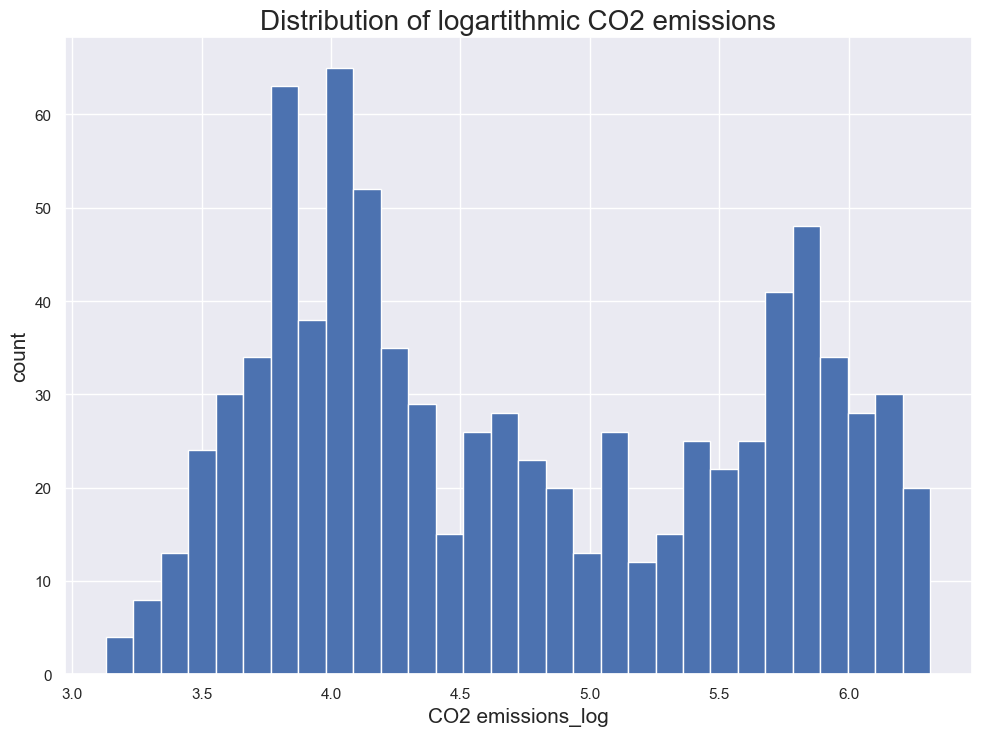

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(y_full, bins=30)
plt.xlabel("CO2 emissions_log", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of logartithmic CO2 emissions', size=20)
plt.show()

In [5]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Renewable energy %   846 non-null    float64
 1   Population           846 non-null    float64
 2   GDP                  846 non-null    float64
 3   Gini                 846 non-null    float64
 4   Low income           846 non-null    int64  
 5   Lower-middle income  846 non-null    int64  
 6   Upper-middle income  846 non-null    int64  
 7   Africa               846 non-null    int64  
 8   Asia                 846 non-null    int64  
 9   North America        846 non-null    int64  
 10  South America        846 non-null    int64  
 11  Oceania              846 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 79.4 KB


In [6]:
X_full = features

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=0.2, random_state=1)
print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

train data (676, 12) (676,)
test data (170, 12) (170,)


In [8]:
numeric_columns=list(X_train.select_dtypes('float64').columns)
dummy_columns=list(X_train.select_dtypes('int64').columns)
categorical_columns = list(X_train.select_dtypes('int64').columns)

In [9]:
categorical_columns_cleaned = [col for col in categorical_columns if col not in dummy_columns]

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, dummy_columns)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [46]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [47]:
X_train_num=X_train[numeric_columns + categorical_columns]
lin_reg.fit(X_train_num, y_train)

LinearRegression()

In [48]:
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train_num, y_train), 2)))
r_squared_3 = lin_reg.score(X_train_num, y_train)

R-squared for training dataset:0.7


In [49]:
lin_reg.fit(X_train_preprocessed, y_train)
print("R-squared for training dataset & preprocessed features:{}".
      format(np.round(lin_reg.score(X_train_preprocessed, y_train), 2)))
r_squared_4 = lin_reg.score(X_train_preprocessed, y_train)

R-squared for training dataset & preprocessed features:0.7


In [15]:
lin_reg.coef_

array([-0.20785104,  0.33915328,  0.49120362, -0.03120045, -1.29472977,
        0.14819421,  0.43515225,  0.13513158,  0.13330429,  0.4074352 ,
       -0.35104384,  0.81357329])

In [16]:
print('The coefficients of the features from the linear model:')
print(dict(zip(numeric_columns + categorical_columns, [round(x, 2) for x in lin_reg.coef_])))

The coefficients of the features from the linear model:
{'Renewable energy %': -0.21, 'Population': 0.34, 'GDP': 0.49, 'Gini': -0.03, 'Low income': -1.29, 'Lower-middle income': 0.15, 'Upper-middle income': 0.44, 'Africa': 0.14, 'Asia': 0.13, 'North America': 0.41, 'South America': -0.35, 'Oceania': 0.81}


In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_preprocessed, y_train)
y_train_pred = lin_reg.predict(X_train_preprocessed)

In [50]:
from sklearn.metrics import mean_squared_error

train_mse_2 = mean_squared_error(y_train, y_train_pred)
train_rmse_2 = np.sqrt(train_mse)
print("RMSE: %s" % train_rmse)

RMSE: 0.48673999735610757


In [51]:
y_test_pred = lin_reg.predict(X_test_preprocessed)    
test_mse_2 = mean_squared_error(y_test, y_test_pred)
test_rmse_2 = np.sqrt(test_mse)
print("RMSE: %s" % test_rmse) 

RMSE: 0.46641474745658107


In [52]:
import statsmodels.api as sm

X = df_clean_without_outliers[["Renewable energy %", "Population", "GDP", "Gini",
              "Low income", "Lower-middle income", "Upper-middle income",
              "Africa", "Asia", "North America", "South America", "Oceania"]]
y = df_clean_without_outliers["CO2 emissions_log"]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

X_with_constant = sm.add_constant(X)

ols_model = sm.OLS(y, X_with_constant)
results = ols_model.fit()

coefficients = lin_reg.coef_

p_values = results.pvalues[1:]

coefficients_with_pvalues = pd.DataFrame({"Coefficient": coefficients, "P-value": p_values}, index=X.columns)

In [53]:
coefficients_with_pvalues

,Coefficient,P-value
Renewable energy %,-1.337030e-02,5.953564e-22
Population,4.908732e-09,2.436716e-37
GDP,8.990151e-13,1.684658e-92
Gini,-7.471301e-02,8.351178e-01
Low income,-1.110345e+00,7.747534e-10
Lower-middle income,1.336485e-01,4.192007e-02
Upper-middle income,4.622760e-01,1.102037e-18
Africa,2.769315e-01,2.239682e-02
Asia,1.397330e-01,2.063070e-02
North America,3.446651e-01,8.200676e-03


In [55]:
goodness_of_fit_2 = pd.DataFrame({"Goodness of fit":[r_squared_3,
                                                     r_squared_4,
                                                     train_rmse_2,
                                                     test_rmse_2]}, index=["R-squared for training dataset:",
                                                                         "R-squared for training dataset & preprocessed features",
                                                                         "Trainingset RMSE",
                                                                        "Testset RMSE"])
goodness_of_fit_2

,Goodness of fit
R-squared for training dataset:,0.696912
R-squared for training dataset & preprocessed features,0.696912
Trainingset RMSE,0.486740
Testset RMSE,0.466415
